In [ ]:
from wetterdienst import Wetterdienst

In [81]:
coverage = Wetterdienst.discover()
coverage

{'dwd': ['observation', 'mosmix', 'dmo', 'road', 'radar', 'derived'],
 'eccc': ['observation'],
 'imgw': ['hydrology', 'meteorology'],
 'noaa': ['ghcn'],
 'wsv': ['pegel'],
 'ea': ['hydrology'],
 'nws': ['observation'],
 'eaufrance': ['hubeau'],
 'geosphere': ['observation']}

## Die am häufigsten verwendeten Parameter-Kombinationen:

### TÄGLICH (daily)
- ("daily", "climate_summary")      # Klima-Übersicht (Temperatur, Niederschlag, Wind, etc.)
- ("daily", "precipitation_more")   # Mehr Niederschlagsdaten
- ("daily", "solar")                # Solarstrahlung
- ("daily", "temperature_soil")     # Bodentemperatur
- ("daily", "weather_phenomena")    # Wetterphänomene (Nebel, Gewitter, etc.)

### STÜNDLICH (hourly)
- ("hourly", "temperature_air")     # Lufttemperatur
- ("hourly", "precipitation")       # Niederschlag
- ("hourly", "wind")                # Wind
- ("hourly", "solar")               # Solarstrahlung
- ("hourly", "pressure")            # Luftdruck
- ("hourly", "cloudiness")          # Bewölkung

### 10 MINUTEN (10_minutes)
- ("10_minutes", "temperature_air")  # Lufttemperatur
- ("10_minutes", "precipitation")    # Niederschlag
- ("10_minutes", "wind")             # Wind
- ("10_minutes", "solar")            # Solarstrahlung

In [ ]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest
from wetterdienst import Settings

def weather_data(start_date: str, end_date: str, parameters: list[tuple], station_id: str):
    request = DwdObservationRequest(
        parameters=parameters,
        start_date=start_date,
        end_date=end_date,
        settings=Settings(
            ts_shape="long",
            ts_humanize=True,
            ts_convert_units=True
        )
    )
    
    # 1. Prüfen, ob die Station existiert
    all_stations = request.all().df
    print(f"Verfügbare Stationen: {len(all_stations)}")
    
    station_exists = all_stations.filter(all_stations["station_id"] == station_id)
    if station_exists.is_empty():
        raise ValueError(f"Station {station_id} nicht gefunden!")
    
    
    # 2. Nach Station filtern
    stations = request.filter_by_station_id(station_id=station_id)
    
    # 3. Generator mit Fehlerbehandlung
    gen = stations.values.query()
    
    try:
        result = next(gen)
    except StopIteration:
        raise ValueError(
            f"Keine Daten für Station {station_id} im Zeitraum "
            f"{start_date} bis {end_date} mit Parametern {parameters}"
        )
    
    # DataFrame bereinigen
    df = result.df.drop_nulls()
    
    if df.is_empty():
        raise ValueError("Alle Daten sind null!")
    
    # Pivotieren
    df_wide = df.pivot(
        values="value",
        index=["station_id", "date"],
        columns="parameter"
    )

    print(f"Daten abgerufen: {df_wide.shape[0]} Zeilen & {df_wide.shape[1]} Spalten")

    return df_wide

In [ ]:
weather_df = weather_data(
    start_date="1990-01-01",
    end_date="2020-01-01",
    parameters=[("daily", "kl"), ("daily", "solar")],
    station_id="00003"
    )

weather_df.head()

Verfügbare Stationen: 1335
Daten abgerufen: 7760 Zeilen & 16 Spalten


/var/folders/q3/v7s38v5s3618gs32r_6k1q180000gn/T/ipykernel_9668/2026544466.py:46: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_wide = df.pivot(


station_id,date,cloud_cover_total,humidity,precipitation_form,precipitation_height,pressure_air_site,pressure_vapor,snow_depth,sunshine_duration,temperature_air_max_2m,temperature_air_mean_2m,temperature_air_min_0_05m,temperature_air_min_2m,wind_gust_max,wind_speed
str,"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00003""",1990-01-01 00:00:00 UTC,1.0,0.9,0.0,0.0,993.3,5.6,0.0,0.0,0.9,0.4,0.0,-0.2,4.6,1.5
"""00003""",1990-01-02 00:00:00 UTC,1.0,0.97,6.0,0.0,995.8,6.5,0.0,0.0,3.1,1.5,-2.4,-2.0,5.7,1.2
"""00003""",1990-01-03 00:00:00 UTC,0.5875,0.89,0.0,0.0,995.3,5.7,0.0,15120.0,3.1,0.1,-3.4,-1.6,6.7,1.9
"""00003""",1990-01-04 00:00:00 UTC,0.75,0.89,6.0,0.0,997.0,5.4,0.0,12240.0,1.8,0.0,-5.6,-2.7,6.7,1.3
"""00003""",1990-01-05 00:00:00 UTC,0.9625,0.88,6.0,0.0,999.6,6.3,0.0,1080.0,3.1,2.2,0.0,0.0,7.2,2.1


shape: (255, 4)
┌──────┬───────┬───────────┬────────────┐
│ year ┆ month ┆ temp_mean ┆ precip_sum │
│ ---  ┆ ---   ┆ ---       ┆ ---        │
│ i32  ┆ i8    ┆ f64       ┆ f64        │
╞══════╪═══════╪═══════════╪════════════╡
│ 1990 ┆ 11    ┆ 6.076667  ┆ 79.9       │
│ 1991 ┆ 4     ┆ 8.503333  ┆ 55.3       │
│ 1991 ┆ 8     ┆ 18.993548 ┆ 33.6       │
│ 1992 ┆ 6     ┆ 16.84     ┆ 113.5      │
│ 2003 ┆ 4     ┆ 10.103333 ┆ 59.9       │
│ …    ┆ …     ┆ …         ┆ …          │
│ 2007 ┆ 6     ┆ 17.496667 ┆ 106.0      │
│ 2007 ┆ 7     ┆ 17.341935 ┆ 109.2      │
│ 2008 ┆ 2     ┆ 5.524138  ┆ 69.7       │
│ 2002 ┆ 1     ┆ 4.722581  ┆ 60.3       │
│ 2002 ┆ 4     ┆ 9.563333  ┆ 51.0       │
└──────┴───────┴───────────┴────────────┘


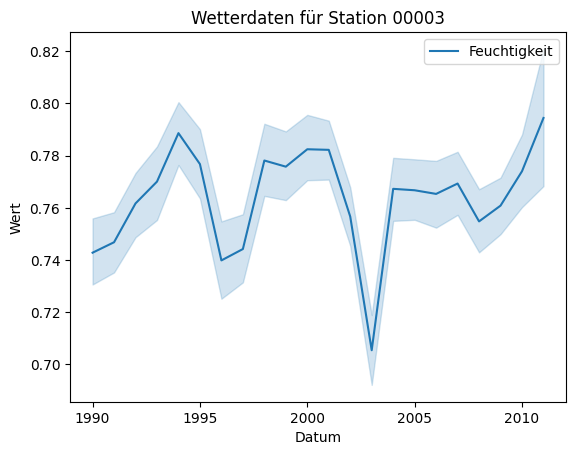

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl


# Monat aus Date extrahieren
weather_df = weather_df.with_columns([
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.year().alias("year")
])

# Nach Jahr und Monat gruppieren
monthly_df = weather_df.group_by(["year", "month"]).agg([
    pl.col("temperature_air_mean_2m").mean().alias("temp_mean"),
    pl.col("precipitation_height").sum().alias("precip_sum"),
    # Weitere Aggregationen...
])

print(monthly_df)

sns.lineplot(data=weather_df, x="year", y="humidity", label="Feuchtigkeit")
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.title("Wetterdaten für Station 00003")
plt.legend() 